# Testing on MNIST Dataset as KAN

- Load MNIST
- Plot some data points
- Transform/preprocess data
- test model


### Performances
- KAN
    - approximation: taylor
    - fraction: 0.01
    - avgpool: k=4
    - epochs: 60
    - results: Train loss:  0.27478| Train acc:  0.92726| Val loss:  0.85571| Val acc:  0.74330
- KAN
    - approximation: spline
    - fraction: 0.1
    - avgpool: k=2
    - epochs: 100
    - results: Train loss:  0.25647| Train acc:  0.94810| Val loss:  0.34361| Val acc:  0.90333
- MLP
    - fraction: 0.1
    - avgpool: k=4
    - epochs: 60
    - results: Train loss:  0.30470| Train acc:  0.90970| Val loss:  0.36589| Val acc:  0.88542

In [1]:
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
import torchmetrics
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import time

import sys
sys.path.append("..")

# import our own modules
from KAN import *

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the training and test datasets
full_trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
full_testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

class_names = full_trainset.classes
full_trainset, full_testset, class_names

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ../data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ../data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

## Plot MNIST

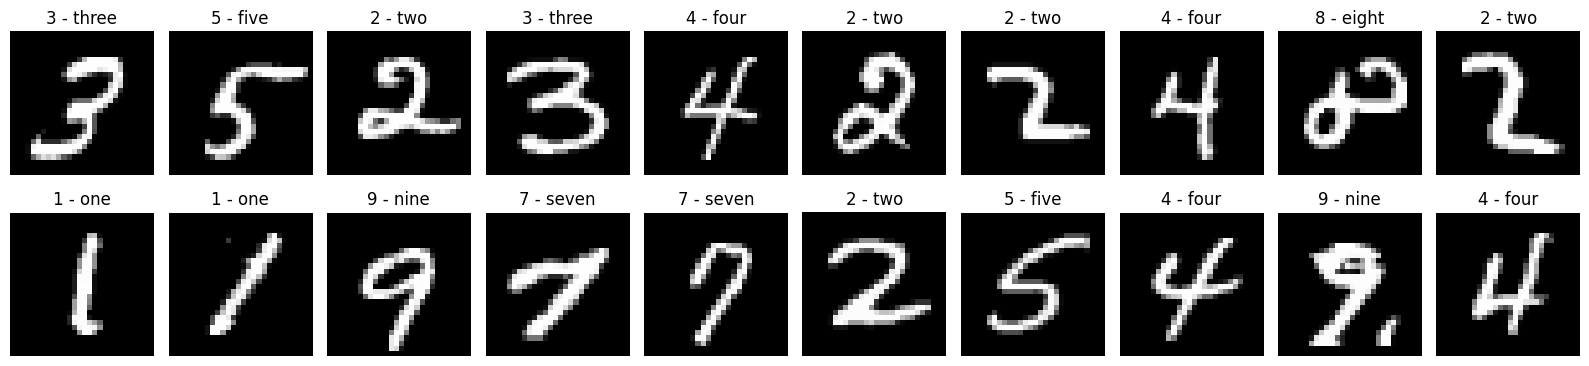

In [3]:
fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(full_trainset), size=[1]).item()
    img, label = full_trainset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

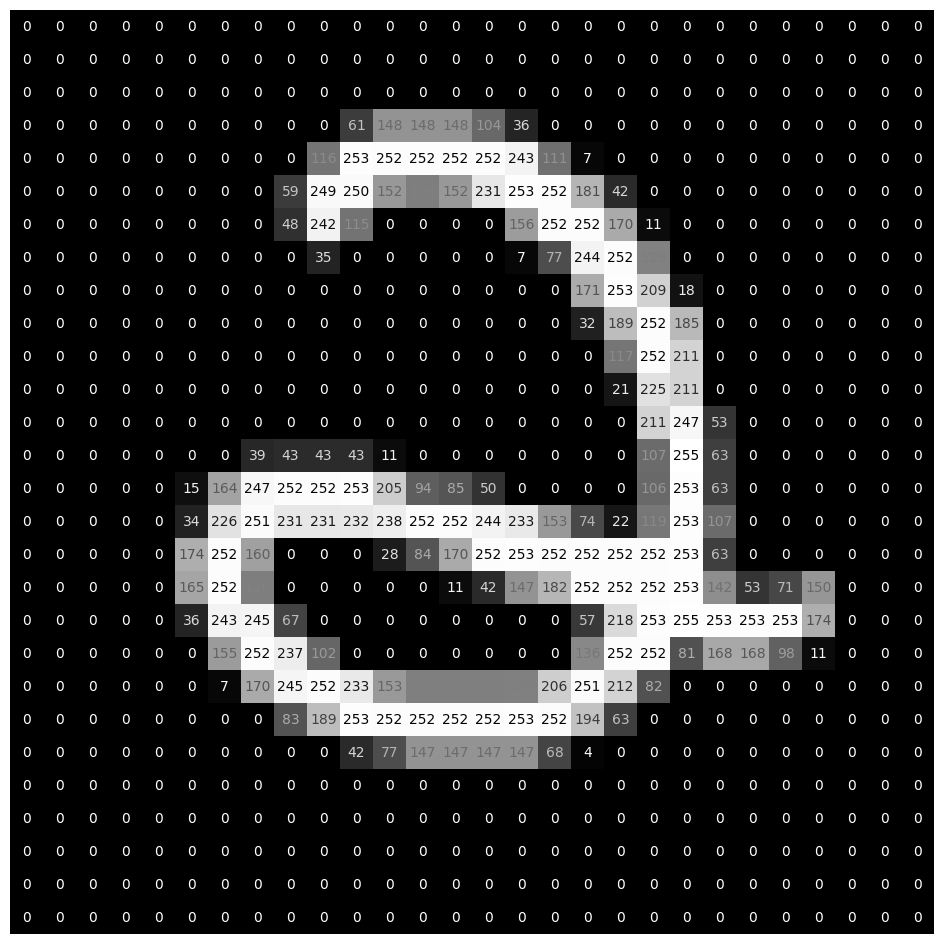

In [4]:
# Print the pixel values of the first image
def img_pixel_superimpose(img, ax, as_int=True):
    w, h = img.shape
    color_map = plt.cm.get_cmap('gray_r')  # gray_reversed
    ax.imshow(img, cmap='gray')
    for x in range(w):
        for y in range(h):
            color = color_map(img[x][y])
            if as_int:
                ax.annotate(str(img[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center',
                        color=color)
            else:
                ax.annotate(f"{{:.{2}g}}".format(img[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center',
                        color=color)
            plt.axis(False)


fig = plt.figure(figsize = (12,12)) 
ax0 = fig.add_subplot(1, 1, 1)

rand_ind = torch.randint(0, len(full_trainset), size=[1]).item()

img0 = full_trainset.data[rand_ind]
img0 = img0.numpy()
img_pixel_superimpose(img0, ax0)

## Some more preprocessing

In [5]:
# Calculate mean and std
imgs = torch.stack([img for img, _ in full_trainset], dim=0)

mean = imgs.view(1, -1).mean(dim=1)    # or imgs.mean()
std = imgs.view(1, -1).std(dim=1)     # or imgs.std()
mean, std

(tensor([0.1307]), tensor([0.3081]))

In [6]:
# Define a transform to normalize the data
# Do we maybe need a min-max scaling here? Because KANs only support a domain of [-1, 1]
# Define a custom transform for min-max scaling to [-1, 1]
class MinMaxScalerToMinusOneToOne:
    def __call__(self, tensor):
        return (tensor - 0.5) * 2
    
mnist_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean, std),
    MinMaxScalerToMinusOneToOne()
])

full_train_dataset = torchvision.datasets.MNIST(root="../data/", train=True, download=False, transform=mnist_transforms)
full_test_dataset = torchvision.datasets.MNIST(root="../data/", train=False, download=False, transform=mnist_transforms)

# Define a function to create a subset of the dataset
def get_subset(dataset, fraction):
    subset_size = int(len(dataset) * fraction)
    indices = torch.randperm(len(dataset))[:subset_size]
    return Subset(dataset, indices)

# Create subsets with only X% of the data
# This speeds up training immensely
fraction = 0.01
train_val_dataset = get_subset(full_train_dataset, fraction)
test_dataset = get_subset(full_test_dataset, fraction)


np.sum([1 for _ in train_val_dataset])

600

In [7]:
# visualize the shape of the datasets
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(540, 60, 100)

In [8]:
# Create DataLoader for the datasets
BATCH_SIZE = 256

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Let's see no of batches that we have now with the current batch-size
len(train_dataloader), len(val_dataloader), len(test_dataloader) 

(3, 1, 1)

In [9]:
# device-agnostic setup
device = "cpu"
min_grid = 3
model = nn.Sequential(
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    MyKAN(width=[14*14, 10], grid=min_grid, degree=3, approx_type="spline", device='cpu')

    # nn.Linear(7*7, 28),
    # nn.ReLU(),
    # nn.Linear(28, 10),
)

# set up metrics
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=10)

In [10]:
# model.train_model(10, train_iteration, 13)

In [11]:
num_epochs = 200
max_grid, curr_grid = 17, min_grid
step = 4

grid_update_freq = int(num_epochs / ((max_grid - min_grid) / step + 1e-5))

epoch_times = []
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    if (epoch + 1) % grid_update_freq == 0 and curr_grid < max_grid and epoch > 0:
        curr_grid += step
        print(f"Updating grid to {curr_grid} in epoch {epoch}")
        model[2].update_grid(curr_grid)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    # Training loop
    train_loss, train_acc = 0.0, 0.0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        model.train()
        
        y_pred = model(X)
        
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        
        acc = accuracy(y_pred, y)
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
        
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y)
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            val_acc += acc
            
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)


    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Train acc: {train_acc: .2f} | Val loss: {val_loss: .4f} | Val acc: {val_acc: .2f} | Time: {epoch_duration:.2f} seconds")

total_time = time.time() - start_time
avg_epoch_time = np.mean(epoch_times)

print(f"Total training time: {total_time:.2f} seconds")
print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")



Epoch: 9 | Train loss:  1.8861 | Train acc:  0.42 | Val loss:  1.9595 | Val acc:  0.33 | Time: 0.28 seconds
Epoch: 19 | Train loss:  1.4564 | Train acc:  0.62 | Val loss:  1.6510 | Val acc:  0.48 | Time: 0.28 seconds
Epoch: 29 | Train loss:  1.1527 | Train acc:  0.77 | Val loss:  1.4108 | Val acc:  0.62 | Time: 0.25 seconds
Epoch: 39 | Train loss:  0.9912 | Train acc:  0.81 | Val loss:  1.2466 | Val acc:  0.62 | Time: 0.27 seconds
Epoch: 49 | Train loss:  0.8024 | Train acc:  0.87 | Val loss:  1.1406 | Val acc:  0.73 | Time: 0.34 seconds
Updating grid to 7 in epoch 56
Epoch: 59 | Train loss:  0.7222 | Train acc:  0.89 | Val loss:  1.0562 | Val acc:  0.72 | Time: 0.36 seconds
Epoch: 69 | Train loss:  0.5601 | Train acc:  0.90 | Val loss:  0.9605 | Val acc:  0.73 | Time: 0.38 seconds
Epoch: 79 | Train loss:  0.4667 | Train acc:  0.93 | Val loss:  0.9084 | Val acc:  0.75 | Time: 0.36 seconds
Epoch: 89 | Train loss:  0.3828 | Train acc:  0.96 | Val loss:  0.8554 | Val acc:  0.78 | Time: 0.

With Grid Extension:
* Epoch: 99 | Train loss:  0.1991 | Train acc:  0.98 | Val loss:  0.4781 | Val acc:  0.92 | Time: 0.53 seconds
* Total training time: 40.78 seconds
* Average time per epoch: 0.41 seconds

* Epoch: 199 | Train loss:  0.2761 | Train acc:  0.96 | Val loss:  0.3533 | Val acc:  0.95 | Time: 0.63 seconds
* Total training time: 85.52 seconds
* Average time per epoch: 0.43 seconds

Without Grid Extension:
* Epoch: 99 | Train loss:  0.2218 | Train acc:  0.99 | Val loss:  0.6000 | Val acc:  0.83 | Time: 0.53 seconds
* Total training time: 52.07 seconds
* Average time per epoch: 0.52 seconds

* Epoch: 199 | Train loss:  0.0831 | Train acc:  1.00 | Val loss:  0.4494 | Val acc:  0.90 | Time: 0.51 seconds
* Total training time: 105.19 seconds
* Average time per epoch: 0.53 seconds